In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import capytaine as cpy

import wecopttool as wot

In [2]:
electrical = True  # power
unstructured = True  # controller
constraint = False

f1 = 0.05
nfreq = 50
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh


scale_x_opt = 1.0  
if (not electrical) and unstructured and constraint:
    scale_x_opt = 1e-2


In [3]:
# fb
wb = wot.geom.WaveBot()  # use standard dimensions
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")

# bem
freq = wot.frequency(f1, nfreq, False)
bem = wot.run_bem(fb, freq)

INFO:capytaine.bodies.bodies:Stored 1052 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.314, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.314, depth=inf, radiating_dof=Heave, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.628, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.628, depth=inf, radiating_dof=Heave, rho=1025.0).
INFO:capytaine.bem.solver:Solve DiffractionProblem(body=WaveBot_immersed, omega=0.942, depth=inf, wave_direction=0.000, rho=1025.0).
INFO:capytaine.bem.solver:Solve RadiationProblem(body=WaveBot_immersed, omega=0.942, depth=inf, 

In [8]:
# hydrostatics
from re import I


mass = wot.hydrostatics.inertia_matrix(fb).values
hstiff = wot.hydrostatics.stiffness_matrix(fb).values

# friction
fric = None

# PTO
ndof = 1
name = ["PTO_Heave",]
kinematics = np.eye(ndof)
controller = None if unstructured else wot.pto.controller_pi
if electrical:
    omega = bem.omega.values
    gear_ratio = 12.0
    torque_constant = 6.7
    winding_resistance = 0.5
    winding_inductance = 0.0
    drivetrain_inertia = 2.0
    drivetrain_friction = 1.0
    drivetrain_stiffness = 0.0

    drivetrain_impedance = (1j*omega*drivetrain_inertia + 
                            drivetrain_friction + 
                            1/(1j*omega)*drivetrain_stiffness) 

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape) 
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance
    pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                            [pto_impedance_21, pto_impedance_22]])
else:
    pto_impedance = None
efficiency = None
pto = wot.pto.PTO(ndof, kinematics, controller, pto_impedance, efficiency, name)

ncomponents_pto = 2*nfreq+1 if unstructured else 2
obj_fun = pto.average_power
f_add = {"PTO": pto.force_on_wec}

# constriaints
if constraint:
    f_max = 2000
    nsubsteps = 4
    def const_f_pto(wec, x_wec, x_opt, waves):
        f = pto.force_on_wec(wec, x_wec, x_opt, nsubsteps)
        return f_max - np.abs(f.flatten())

    ineq_cons = {'type': 'ineq',
                'fun': const_f_pto,
                }
    cons = [ineq_cons]
else:
    cons = []

wec = wot.WEC.from_bem(bem, mass, hstiff, fric, f_add, cons)

INFO:capytaine.bodies.bodies:Clipping WaveBot_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])


In [9]:
# waves
wfreq = 0.3
wamp = 0.0625 
wphase = 30
wdir = 0
waves = wot.waves.regular_wave(f1, nfreq, wfreq, wamp, wphase, wdir)

# solve
scale_x_opt = 1.0
res_fd, res_td, res = wec.solve(waves, obj_fun, ncomponents_pto,
                                scale_x_opt=scale_x_opt)

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 1.72e+01, 1.19e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 1.72e+01, 1.19e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 1.71e+01, 1.17e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.47e-02, 1.65e+01, 1.07e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.49e-02, 1.34e+01, 5.87e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.57e-02, 3.85e+01, -1.54e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [5.91e-02, 1.68e+02, -6.55e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [6.00e-02, 2.05e+02, -6.83e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [6.01e-02, 2.08e+02, -6.86e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [6.02e-02, 2.11e+02, -7.00e+00]
INFO:wecopttool.core:[max(x_wec),

Optimization terminated successfully    (Exit mode 0)
            Current function value: -28.894831572968474
            Iterations: 38
            Function evaluations: 38
            Gradient evaluations: 38


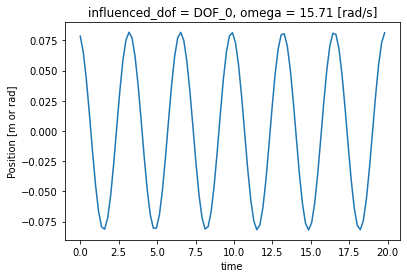

In [10]:
res_td.pos.plot()

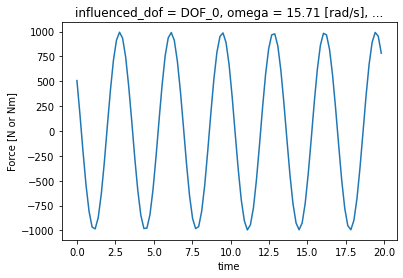

In [11]:
res_td.force.sel(type='PTO').plot()